In [2]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook: ', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook:  3.8.8


#Carga de Dados Executada com VirtualEnv
#python -m venv venv
#pipenv install imdb-sqlite
#imdb-sqlite

In [3]:
%pip install -q pycountry

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

In [5]:
conn = sqlite3.connect('imdb.db')
tabelas = pd.read_sql_query("select name as 'Table_Name' from sqlite_master where type='table'", conn)

In [6]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [7]:
tabelas = tabelas['Table_Name'].values.tolist()
for tabela in tabelas:
    consulta = f"pragma table_info({tabela})"
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ", tabela)
    display(resultado)
    print("-"*100 + "\n")

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------



**1- Quais são as categorias de Filmes mais comuns no IMDB?**

In [8]:
consulta1 = '''select type, count(*) as count from titles group by type'''

In [9]:
resultado1 = pd.read_sql_query(consulta1, conn)
display(resultado1)

,type,count
0,movie,602910
1,short,857469
2,tvEpisode,6526093
3,tvMiniSeries,42239
4,tvMovie,135095
5,tvPilot,2
6,tvSeries,221542
7,tvShort,10466
8,tvSpecial,36040
9,video,257670


In [10]:
resultado1['percentual'] = (resultado1['count']/resultado1['count'].sum()) * 100
display(resultado1)

,type,count,percentual
0,movie,602910,6.914078
1,short,857469,9.833321
2,tvEpisode,6526093,74.840216
3,tvMiniSeries,42239,0.484390
4,tvMovie,135095,1.549248
5,tvPilot,2,0.000023
6,tvSeries,221542,2.540609
7,tvShort,10466,0.120022
8,tvSpecial,36040,0.413301
9,video,257670,2.954919


In [11]:
#Grafico com 4 categorias
others = {}
others['count'] = resultado1[resultado1['percentual'] < 5]['count'].sum()
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()
others['type'] = 'others'
others

{'count': 733563, 'percentual': 8.412385959460025, 'type': 'others'}

In [12]:
resultado1 = resultado1[resultado1['percentual'] > 5]
resultado1 = resultado1.append(others, ignore_index=True)
resultado1 = resultado1.sort_values(by='count', ascending=False)
resultado1.head()

,type,count,percentual
2,tvEpisode,6526093,74.840216
1,short,857469,9.833321
3,others,733563,8.412386
0,movie,602910,6.914078


In [13]:
labels = [str(resultado1['type'][i])+' '+'['+ str(round(resultado1['percentual'][i],2)) +'%]' for i in resultado1.index]

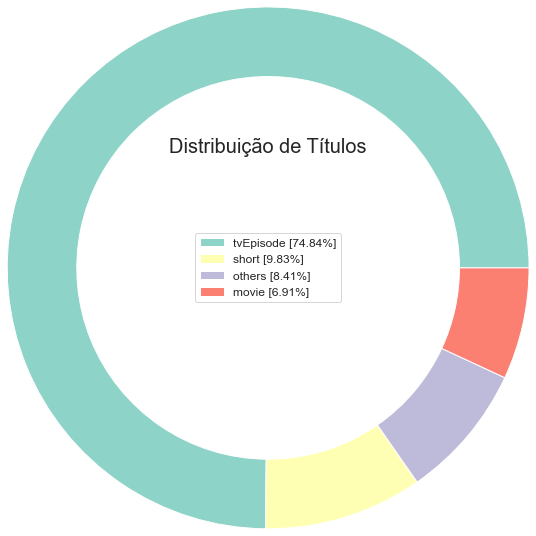

In [14]:
cs = cm.Set3(np.arange(100))
plt.pie(resultado1['count'], labeldistance=1, radius=3, colors=cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc='center', prop={'size':12})
plt.title('Distribuição de Títulos', loc='center', fontdict={'fontsize':20,'fontweight':20})
plt.show()

**2- Qual o Número de Títulos Por Gênero?**

In [15]:
consulta2 = '''select genres, count(*) as count from titles where type='movie' group by genres'''
resultado2 = pd.read_sql_query(consulta2, conn)
display(resultado2)

,genres,count
0,Action,13837
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1446,"Thriller,Western",43
1447,War,1288
1448,"War,Western",14
1449,Western,5103


In [16]:
resultado2['genres'] = resultado2['genres'].str.lower().values
temp = resultado2['genres'].dropna()

In [17]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern=padrao, analyzer='word').fit(temp)
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [18]:
bag_generos = vetor.transform(temp)
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [19]:
generos_unicos = vetor.get_feature_names()
generos = pd.DataFrame(bag_generos.todense(), columns=generos_unicos, index=temp.index)
generos = generos.drop(columns='n', axis=0)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  news         1451 non-null   int64
 19  reality-tv   1451 non-null   int64
 20  romance 

In [20]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]
generos_percentual.head(10)

drama          18.194349
comedy         16.815989
documentary    15.851137
adventure      14.817367
action         14.403859
romance        13.370090
crime          13.094418
mystery        12.474156
thriller       12.336320
fantasy        12.198484
dtype: float64

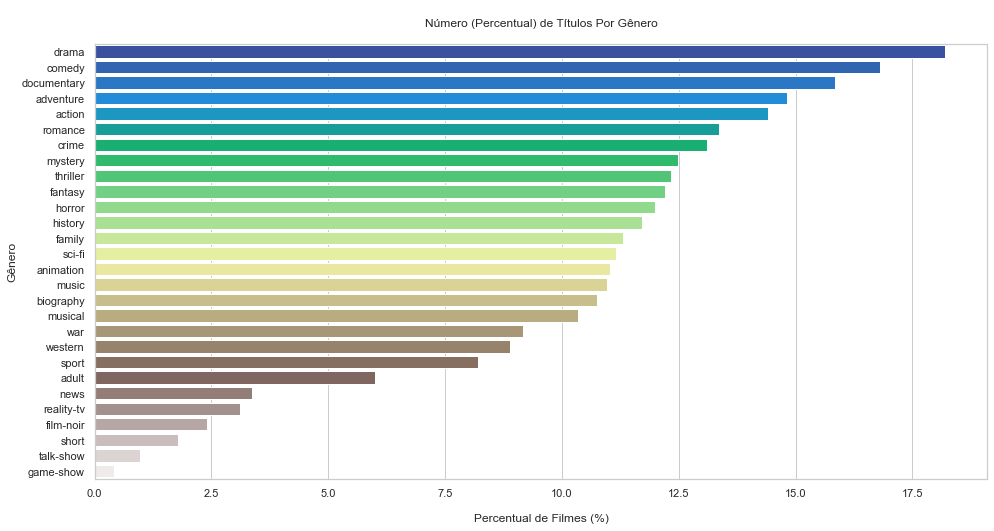

In [21]:
plt.figure(figsize=(16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient='h', palette='terrain')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes (%)')
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

**3- Qual a Mediana de Avaliação dos Filmes Por Gênero?**

In [22]:
consulta3 = '''
    select rating, genres from
    ratings join titles on ratings.title_id = titles.title_id
    where premiered <= 2022 and type='movie' 
'''
resultado3 = pd.read_sql_query(consulta3, conn)

In [23]:
print(type(resultado3))
display(resultado3)

<class 'pandas.core.frame.DataFrame'>


,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,4.6,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
275169,5.8,Thriller
275170,6.4,"Drama,History"
275171,3.8,"Adventure,History,War"
275172,8.3,Drama


In [24]:
def retorna_generos(df :pd.DataFrame):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre)>1]
    return generos_unicos

In [25]:
generos_unicos = retorna_generos(resultado3)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [26]:
genero_counts = []
genero_ratings = []
for item in generos_unicos:
    consulta = 'select count(rating) from ratings join titles on ratings.title_id = titles.title_id where genres like '+'\'%'+ item +'%\''+' and type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])

    consulta = 'select rating from ratings join titles on ratings.title_id = titles.title_id where genres like '+'\'%'+ item +'%\''+' and type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [27]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings
df_genero_ratings.head(20)

,genres,count,rating
0,action,28523,5.8
1,adult,4307,5.9
2,adventure,17297,6.0
3,animation,4731,6.6
4,biography,8302,7.0
5,comedy,68171,6.0
6,crime,23494,6.1
7,documentary,40843,7.3
8,drama,121898,6.3
9,family,10647,6.3


In [28]:
df_genero_ratings = df_genero_ratings.drop(index=18)
df_genero_ratings = df_genero_ratings.sort_values(by='rating', ascending=False)

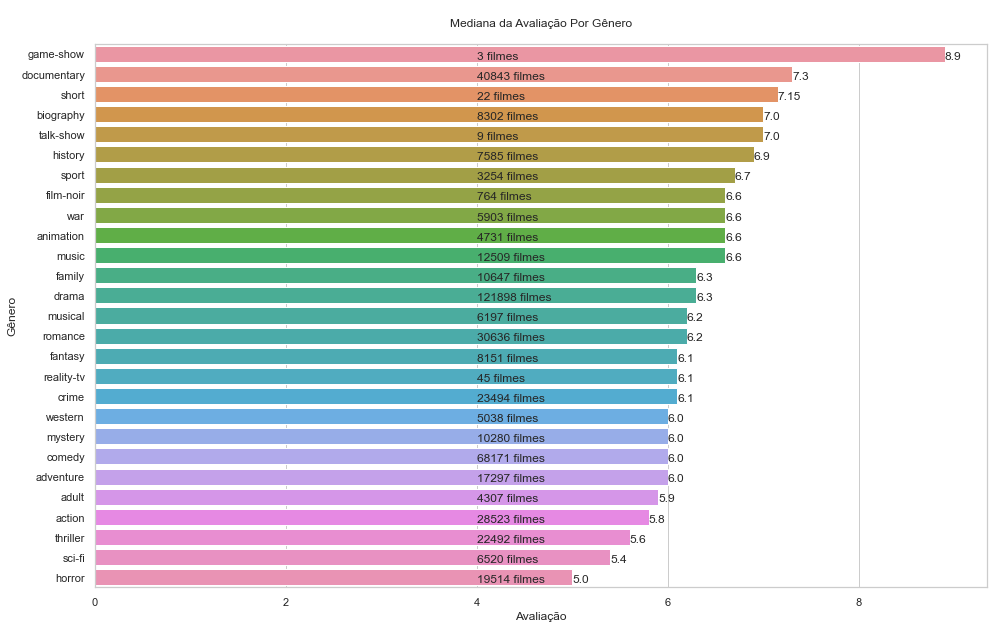

In [29]:
plt.figure(figsize=(16,10))
sns.barplot(y=df_genero_ratings.genres, x=df_genero_ratings.rating, orient='h')
for i in range(len(df_genero_ratings.index)):
    plt.text(4.0, i+0.25, str(df_genero_ratings['count'][df_genero_ratings.index[i]])+' filmes')
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]], i+0.25, round(df_genero_ratings.rating[df_genero_ratings.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('Avaliação')
plt.title('\nMediana da Avaliação Por Gênero\n')
plt.show()

**4- Qual a Mediana de Avaliação de Filmes em Relação ao Ano de Estréia?**

In [30]:
consulta4 = '''
    select rating, premiered from
    ratings join titles on ratings.title_id = titles.title_id
    where premiered <= 2022 and type = 'movie'
    order by premiered
    '''
resultado4 = pd.read_sql_query(consulta4, conn)
display(resultado4)

,rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
275169,3.7,2022
275170,4.0,2022
275171,10.0,2022
275172,6.1,2022


In [31]:
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['rating']))
type(ratings)

list

In [32]:
ratings[1:10]

[4.5, 3.85, 5.85, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [33]:
years = list(set(resultado4['premiered']))
years[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

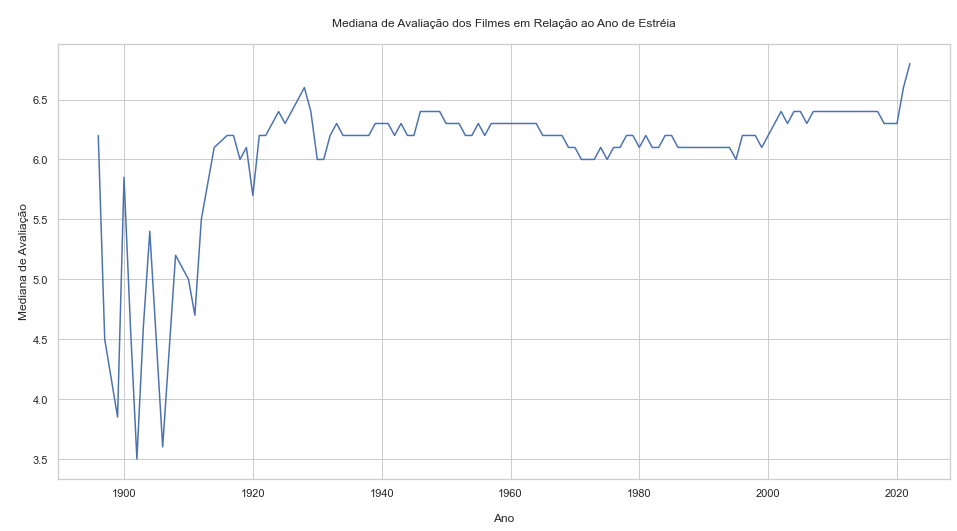

In [34]:
plt.figure(figsize=(16,8))
plt.plot(years, ratings)
plt.xlabel('\nAno')
plt.ylabel('\nMediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes em Relação ao Ano de Estréia\n')
plt.show()

**5- Qual o Número de Filmes Avaliados Por Gênero em Relação ao Ano de Estréia?**

In [37]:
consulta5 = 'select genres from titles'
resultado5 = pd.read_sql_query(consulta5, conn)
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8720030,"Action,Drama,Family"
8720031,"Action,Drama,Family"
8720032,"Action,Drama,Family"
8720033,Short


In [38]:
generos_unicos = retorna_generos(resultado5)

In [39]:
genero_count = []
for item in generos_unicos:
    consulta = 'select count(*) as count from titles where genres like \'%'+item+'%\' and type=\'movie\' and premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['count'].values[0])

In [40]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['count'] = genero_count
df_genero_count = df_genero_count[df_genero_count['genre']!='n']
df_genero_count = df_genero_count.sort_values(by='count', ascending=False)
top_generos = df_genero_count.head()['genre'].values

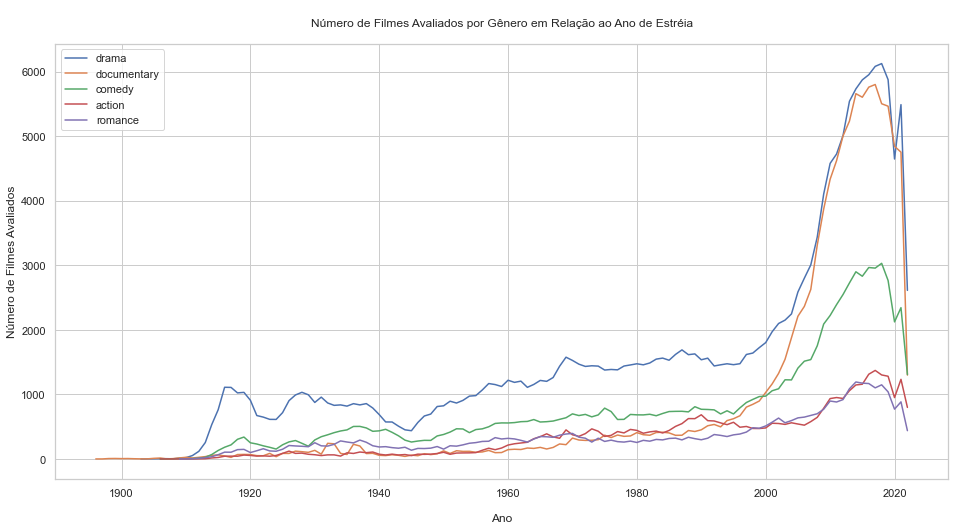

In [44]:
plt.figure(figsize=(16,8))
for item in top_generos:
    consulta = 'select count(*) as number_of_movies, premiered as year from titles where genres like \'%'+item+'%\' and type=\'movie\' and premiered <= 2022 group by premiered'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['year'], resultado['number_of_movies'])
plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados por Gênero em Relação ao Ano de Estréia\n')
plt.legend(labels=top_generos)
plt.show()

**6- Qual o Filme com Maior Tempo de Duração? Calcule os Percentis.**

In [45]:
consulta6 = '''
    select runtime_minutes runtime
    from titles
    where type = 'movie' and runtime_minutes != 'NaN'
'''
resultado6 = pd.read_sql_query(consulta6, conn)
display(resultado6)

,runtime
0,100
1,70
2,90
3,120
4,58
...,...
379223,123
379224,57
379225,100
379226,116


In [46]:
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['runtime'].values, val),2)
    print(f'{val} percentil da duração (runtime) é: {perc}')

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [47]:
consulta6 = '''
    select runtime_minutes runtime, primary_title title
    from titles
    where type = 'movie' and runtime_minutes != 'NaN'
    order by runtime_minutes desc
    limit 1
'''
resultado6 = pd.read_sql_query(consulta6, conn)
display(resultado6)

,runtime,title
0,51420,Logistics


**7- Qual a Relação Entre Duração e Gênero?**

In [51]:
consulta7 = '''
    select avg(runtime_minutes) runtime, genres
    from titles
    where type='movie'
    and runtime_minutes != 'NaN'
    group by genres
'''
resultado7 = pd.read_sql_query(consulta7, conn)
display(resultado7)

,runtime,genres
0,99.186211,Action
1,77.000000,"Action,Adult"
2,105.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1361,94.266667,"Thriller,Western"
1362,94.081126,War
1363,93.636364,"War,Western"
1364,70.676858,Western


In [52]:
generos_unicos = retorna_generos(resultado7)

In [57]:
generos_runtime = []
for item in generos_unicos:
    consulta = 'select runtime_minutes runtime from titles where genres like \'%'+item+'%\' and type=\'movie\' and runtime_minutes != \'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    generos_runtime.append(np.median(resultado['runtime']))

df_genero_runtime = pd.DataFrame()
df_genero_runtime['genres'] = generos_unicos
df_genero_runtime['runtime'] = generos_runtime

In [58]:
df_genero_runtime = df_genero_runtime.drop(index=18)
df_genero_runtime = df_genero_runtime.sort_values(by='runtime', ascending=False)

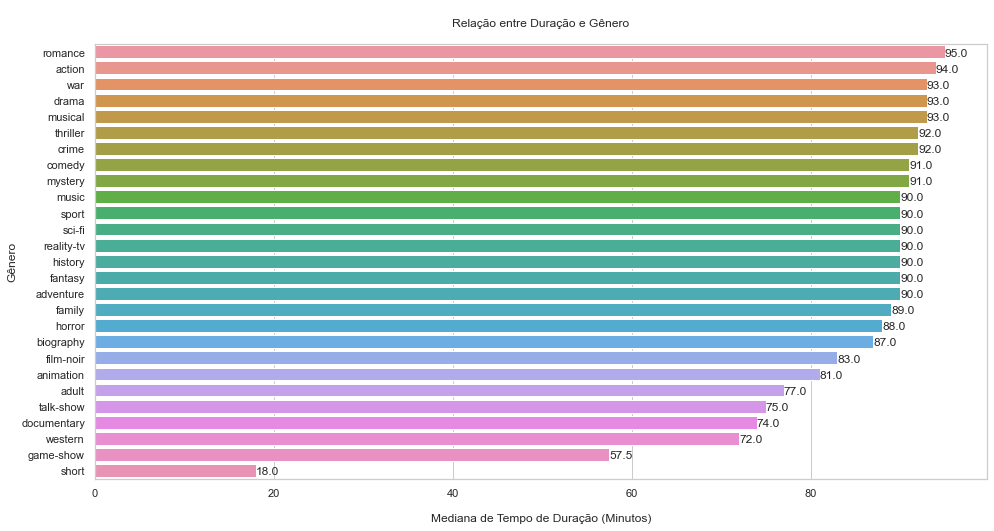

In [60]:
plt.figure(figsize=(16,8))
sns.barplot(y=df_genero_runtime.genres, x=df_genero_runtime.runtime, orient='h')
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]], i+0.25
    , round(df_genero_runtime.runtime[df_genero_runtime.index[i]],2))
plt.ylabel('Gênero')
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação entre Duração e Gênero\n')
plt.show()

**8- Qual o Número de Filmes produzidos por País?**

In [61]:
consulta8 = '''
    select region, count(*) number_of_movies
    from akas join titles on akas.title_id = titles.title_id
    where region != 'None' and type='movie'
    group by region
'''
resultado8 = pd.read_sql_query(consulta8, conn)
display(resultado8)

,region,number_of_movies
0,AD,22
1,AE,5136
2,AF,110
3,AG,12
4,AL,1269
...,...,...
229,YUCS,153
230,ZA,3170
231,ZM,15
232,ZRCD,2


In [62]:
nomes_paises = []
contagem = []
for i in range(resultado8.shape[0]):
    try:
        country = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = country).name)
        contagem.append(resultado8['number_of_movies'].values[i])
    except:
        continue

In [63]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['movie_count'] = contagem

In [65]:
df_filmes_paises = df_filmes_paises.sort_values(by='movie_count', ascending=False)

In [66]:
df_filmes_paises.head(10)

,country,movie_count
199,United States,307397
65,United Kingdom,158063
96,Japan,90756
63,France,83938
89,India,79483
32,Canada,76020
47,Germany,69861
93,Italy,64939
58,Spain,64735
26,Brazil,64616


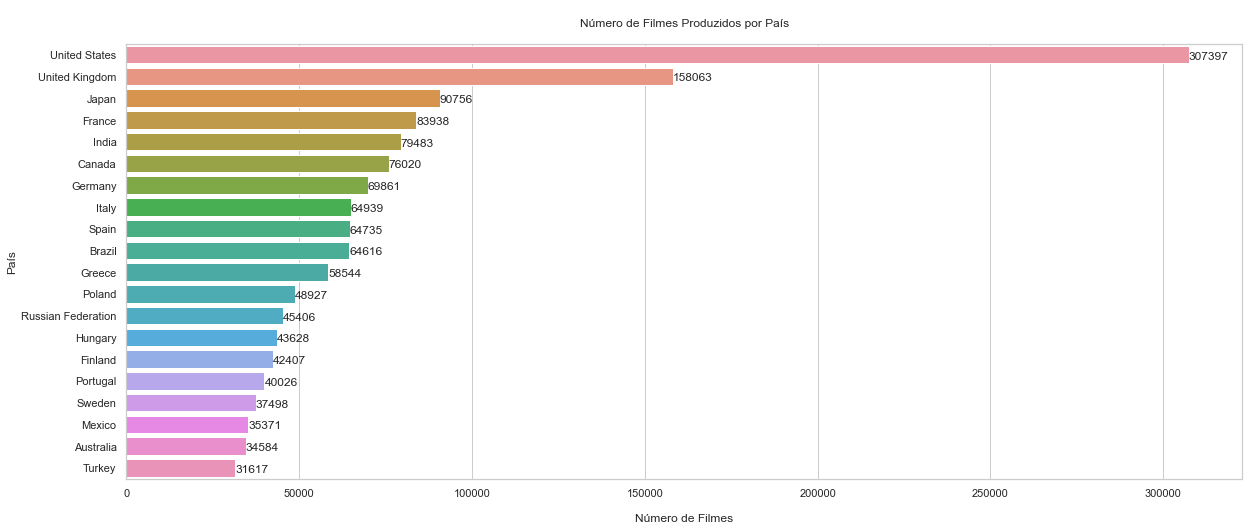

In [78]:
plt.figure(figsize=(20,8))
sns.barplot(y=df_filmes_paises[:20].country, x=df_filmes_paises[:20].movie_count, orient='h')
for i in range(0,20):
    plt.text(df_filmes_paises.movie_count[df_filmes_paises.index[i]]-1, i+0.2
    ,round(df_filmes_paises.movie_count[df_filmes_paises.index[i]],2))
plt.ylabel('País')
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos por País\n')
plt.show()

**9- Quais são os Top 10 Melhores Filmes?**

In [79]:
consulta9 = '''
    select primary_title as movie_name, genres, rating
    from titles join ratings on titles.title_id = ratings.title_id
    where titles.type = 'movie' and ratings.votes >= 25000
    order by rating desc
    limit 10
'''
resultado9 = pd.read_sql_query(consulta9, conn)
display(resultado9)

,movie_name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,Jai Bhim,"Crime,Drama,Mystery",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
6,Mirror Game,"Crime,Mystery,Thriller",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


**10- Quais são od Top 10 Piores Filmes?**

In [80]:
consulta10 = '''
    select primary_title as movie_name, genres, rating
    from titles join ratings on titles.title_id = ratings.title_id
    where titles.type = 'movie' and ratings.votes >= 25000
    order by rating asc
    limit 10
'''
resultado10 = pd.read_sql_query(consulta10, conn)
display(resultado10)

,movie_name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Reis,"Biography,Drama",1.4
4,The Cost of Deception,"Crime,Drama,History",1.5
5,Justin Bieber: Never Say Never,"Documentary,Music",1.6
6,Manos: The Hands of Fate,Horror,1.8
7,Radhe,"Action,Crime,Thriller",1.8
8,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
